In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, AgglomerativeClustering, dbscan
import scipy.cluster.hierarchy as shc
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler,PowerTransformer
from sklearn.metrics import adjusted_rand_score

In [2]:

order_df=pd.read_csv('merged_clean.csv',sep='\t')

Pour évaluer la stabilité de nos segments au cours du temps, nous allons procéder de la maniere suivante:


On entraine notre modele au temps T_0 (On choisit un T_0 equivalant à un an de semaines.

On predit les segments du jeux de données au temps T_n = T_0 + n semaines à l'aide de ce modèle

On entraine un modèle et on prédit les segments au temps T1

On compare les deux résultats obtenue a l'aide de l'ARI

On regardera l'évolution du score ARI obtenue en fonction des valeurs de n


In [3]:
num=['Recency','Frequency','Monetary','delivery_time','review_score']
cat=['product_category_name_english','month','day','review_comment_title']

In [4]:
order_df['order_purchase_timestamp']=order_df['order_purchase_timestamp'].astype('datetime64')

In [5]:
#Découpe la période étudié en période de une semaine
date_range=pd.date_range(start=order_df['order_purchase_timestamp'].min(),
                         end=order_df['order_purchase_timestamp'].max(),freq='7D')
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113202 entries, 0 to 113201
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    113202 non-null  object        
 1   customer_state                 113202 non-null  object        
 2   order_purchase_timestamp       113202 non-null  datetime64[ns]
 3   shipping_limit_date            113202 non-null  object        
 4   freight_value                  113202 non-null  float64       
 5   payment_value                  113202 non-null  float64       
 6   review_score                   113202 non-null  int64         
 7   review_comment_title           113202 non-null  int64         
 8   product_category_name_english  113202 non-null  object        
 9   delivery_time                  113202 non-null  int64         
 10  month                          113202 non-null  int64         
 11  

In [6]:
date_range

DatetimeIndex(['2016-10-03 09:44:50', '2016-10-10 09:44:50',
               '2016-10-17 09:44:50', '2016-10-24 09:44:50',
               '2016-10-31 09:44:50', '2016-11-07 09:44:50',
               '2016-11-14 09:44:50', '2016-11-21 09:44:50',
               '2016-11-28 09:44:50', '2016-12-05 09:44:50',
               '2016-12-12 09:44:50', '2016-12-19 09:44:50',
               '2016-12-26 09:44:50', '2017-01-02 09:44:50',
               '2017-01-09 09:44:50', '2017-01-16 09:44:50',
               '2017-01-23 09:44:50', '2017-01-30 09:44:50',
               '2017-02-06 09:44:50', '2017-02-13 09:44:50',
               '2017-02-20 09:44:50', '2017-02-27 09:44:50',
               '2017-03-06 09:44:50', '2017-03-13 09:44:50',
               '2017-03-20 09:44:50', '2017-03-27 09:44:50',
               '2017-04-03 09:44:50', '2017-04-10 09:44:50',
               '2017-04-17 09:44:50', '2017-04-24 09:44:50',
               '2017-05-01 09:44:50', '2017-05-08 09:44:50',
               '2017-05-

In [7]:
#Preprocessor utilisé pour le Tsne
num=['Frequency' , 'Recency', 'Monetary']
preprocessor_tsne = ColumnTransformer(transformers=[
        ('numeric',RobustScaler(), num),
    ])

numerical_features=['Recency','Frequency','Monetary']
#Preprocessor utilisé pour le DBscan
preprocessor = ColumnTransformer([
        ('scaler',RobustScaler() , numerical_features)])

In [8]:
#Crée les variables Recency, Frequency et Monetary correspondantes au dataframe df
def RFM_eval(df):   
    #Création du dataframe recency
    merged=df
    merged_recency = merged.groupby(by='customer_id',
                            as_index=False)['order_purchase_timestamp'].max()
    merged_recency.columns = ['customer_id', 'LastPurchaseDate']
    recent_date = merged_recency['LastPurchaseDate'].max()
    merged_recency['Recency'] = merged_recency['LastPurchaseDate'].apply(
        lambda x: (recent_date - x).days)
    merged_recency.head()

    #Création du dataframe frequency
    frequency_merged = merged.drop_duplicates().groupby(
        by=['customer_id'], as_index=False)['order_purchase_timestamp'].count()
    frequency_merged.columns = ['customer_id', 'Frequency']
    frequency_merged.head()


    #Création du dataframe 'monetary'
    monetary_merged = merged.groupby(by='customer_id', as_index=False)['payment_value'].sum()
    monetary_merged.columns = ['customer_id', 'Monetary']
    monetary_merged.head()

    #merge des Dataframe
    rf_merged = merged_recency.merge(frequency_merged, on='customer_id')
    rfm_merged = rf_merged.merge(monetary_merged, on='customer_id').drop(
        columns='LastPurchaseDate')
    rfm_merged.head()
    
    return rfm_merged

In [9]:
#Effectue le préprocessing du Dataframe de commande : df et le merge avec le Dataframe de RFM : rfm
def to_merge(df,rfm):
    merged=df
    rfm_merged=rfm
    temp=merged.groupby("customer_id")\
        .agg({"review_score" : "mean",
             "delivery_time" : 'mean',
             "review_comment_title": "max",
              "customer_state": lambda x:x.mode(),
             "day": lambda x:x.mode(),
             "month": lambda x:x.mode(),
             "product_category_name_english": lambda x:x.mode().explode()})
    rfm_merged=rfm_merged.merge(temp, on=["customer_id"], how="inner")
    rfm_merged['product_category_name_english']=rfm_merged['product_category_name_english'].map(
        lambda cat : cat if isinstance(cat,str) else cat[0])
    return rfm_merged

In [10]:
#Retourne le modèle kmean entrainé sur le dataframe df
def kmean(df):
    numerical_features=df.columns

    Kmean_clus=Pipeline([("preprocessor", preprocessor),
                        ("kmeans", KMeans(4,random_state=0))])
    segment=Kmean_clus
    segment.fit(df)
    return segment

In [11]:

Tsne = Pipeline([
            ('preprocessor', preprocessor_tsne),
            ('tsne', TSNE(n_components=2, verbose=1,perplexity=150))])

        
        


In [12]:
def db_ml(z):
    db=dbscan(z,eps=0.8,min_samples=8)[1]
    return db

In [13]:

#Effectue le preprocessing des données au temps T_n
#Entraine et predit les données avec des modèles entrainé au temps T_n
#Retourne le DataFrame de préprocessing et les segmentations obtenue

def cluster_Tn(date):
    if len(order_df[order_df['order_purchase_timestamp']<date])>0:
        results=pd.DataFrame()
        df=order_df[order_df['order_purchase_timestamp']<date]
        df_rfm=RFM_eval(df)
        df_prepro=to_merge(df,df_rfm)
        
        

        
        z=Tsne.fit_transform(df_prepro[['Frequency' , 'Recency', 'Monetary']])
        
        results['customer_id']=df_prepro['customer_id']
        
        results['km1']=kmean(df_prepro[['Frequency' , 'Recency', 'Monetary']]).predict(
            df_prepro[['Frequency' , 'Recency', 'Monetary']])  
        results['dbscan']=db_ml(z)
        
        return (results,df_prepro)
            
    
        
        

In [14]:
#Predit les données au temps T_n avec le modèle entrainer au temps T_0
#Retourne les segmentations obtenues
def cluster_T0(df_T1):

        
    results=pd.DataFrame()

    z_T1=Tsne_T0['preprocessor'].transform(df_T1[['Frequency' , 'Recency', 'Monetary']])
    z_T1=TSNE(n_components=2, verbose=0,perplexity=120).fit_transform(z_T1)

    results['customer_id']=df_T1['customer_id']

    results['km1']=km1_mdl_T0.predict(df_T1[['Frequency' , 'Recency', 'Monetary']]) 


    results['dbscan']=db_ml(z_T1)


    return results

In [15]:
#Retourne les score ARI obtenue entre les deux segmentations
def ARI_t0_t1(date_T1):
    (results_m1 ,df_prepro_T1)=cluster_Tn(date_T1)
    results_m0 =cluster_T0(df_prepro_T1)
    
    result_km1=adjusted_rand_score(results_m0['km1'],results_m1['km1'])
    result_dbscan=adjusted_rand_score(results_m0['dbscan'],results_m1['dbscan'])
    
    
    
    return [date_T1,result_km1,result_dbscan]
    
    
    
    
    
    

In [16]:
T0=date_range[47]

#Préprocessing des données au temps T_0
results_T0=pd.DataFrame()
df_T0=order_df[order_df['order_purchase_timestamp']<T0]
df_rfm_T0=RFM_eval(df_T0)
df_prepro_T0=to_merge(df_T0,df_rfm_T0)

#Entrainement des modèles au temps T_0
Tsne_T0=Tsne
z_T0=Tsne_T0.fit_transform(df_prepro_T0[['Frequency' , 'Recency', 'Monetary']])
km1_mdl_T0=kmean(df_prepro_T0[['Frequency' , 'Recency', 'Monetary']])


ari_result=pd.DataFrame(columns=['date','kmean','dbscan'])


for date in date_range[47:67]:
    ari_result.loc[len(ari_result.index)] = ARI_t0_t1(date)
    print(ari_result)
    
    
    

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 21112 samples in 0.019s...
[t-SNE] Computed neighbors for 21112 samples in 2.011s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21112
[t-SNE] Computed conditional probabilities for sample 2000 / 21112
[t-SNE] Computed conditional probabilities for sample 3000 / 21112
[t-SNE] Computed conditional probabilities for sample 4000 / 21112
[t-SNE] Computed conditional probabilities for sample 5000 / 21112
[t-SNE] Computed conditional probabilities for sample 6000 / 21112
[t-SNE] Computed conditional probabilities for sample 7000 / 21112
[t-SNE] Computed conditional probabilities for sample 8000 / 21112
[t-SNE] Computed conditional probabilities for sample 9000 / 21112
[t-SNE] Computed conditional probabilities for sample 10000 / 21112
[t-SNE] Computed conditional probabilities for sample 11000 / 21112
[t-SNE] Computed conditional probabilities for sample 12000 / 21112
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 21112 samples in 0.019s...
[t-SNE] Computed neighbors for 21112 samples in 1.989s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21112
[t-SNE] Computed conditional probabilities for sample 2000 / 21112
[t-SNE] Computed conditional probabilities for sample 3000 / 21112
[t-SNE] Computed conditional probabilities for sample 4000 / 21112
[t-SNE] Computed conditional probabilities for sample 5000 / 21112
[t-SNE] Computed conditional probabilities for sample 6000 / 21112
[t-SNE] Computed conditional probabilities for sample 7000 / 21112
[t-SNE] Computed conditional probabilities for sample 8000 / 21112
[t-SNE] Computed conditional probabilities for sample 9000 / 21112
[t-SNE] Computed conditional probabilities for sample 10000 / 21112
[t-SNE] Computed conditional probabilities for sample 11000 / 21112
[t-SNE] Computed conditional probabilities for sample 12000 / 21112
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date  kmean    dbscan
0 2017-08-28 09:44:50    1.0  0.662046


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 22062 samples in 0.021s...
[t-SNE] Computed neighbors for 22062 samples in 2.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22062
[t-SNE] Computed conditional probabilities for sample 2000 / 22062
[t-SNE] Computed conditional probabilities for sample 3000 / 22062
[t-SNE] Computed conditional probabilities for sample 4000 / 22062
[t-SNE] Computed conditional probabilities for sample 5000 / 22062
[t-SNE] Computed conditional probabilities for sample 6000 / 22062
[t-SNE] Computed conditional probabilities for sample 7000 / 22062
[t-SNE] Computed conditional probabilities for sample 8000 / 22062
[t-SNE] Computed conditional probabilities for sample 9000 / 22062
[t-SNE] Computed conditional probabilities for sample 10000 / 22062
[t-SNE] Computed conditional probabilities for sample 11000 / 22062
[t-SNE] Computed conditional probabilities for sample 12000 / 22062
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 22925 samples in 0.020s...
[t-SNE] Computed neighbors for 22925 samples in 2.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22925
[t-SNE] Computed conditional probabilities for sample 2000 / 22925
[t-SNE] Computed conditional probabilities for sample 3000 / 22925
[t-SNE] Computed conditional probabilities for sample 4000 / 22925
[t-SNE] Computed conditional probabilities for sample 5000 / 22925
[t-SNE] Computed conditional probabilities for sample 6000 / 22925
[t-SNE] Computed conditional probabilities for sample 7000 / 22925
[t-SNE] Computed conditional probabilities for sample 8000 / 22925
[t-SNE] Computed conditional probabilities for sample 9000 / 22925
[t-SNE] Computed conditional probabilities for sample 10000 / 22925
[t-SNE] Computed conditional probabilities for sample 11000 / 22925
[t-SNE] Computed conditional probabilities for sample 12000 / 22925
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 24037 samples in 0.021s...
[t-SNE] Computed neighbors for 24037 samples in 2.333s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24037
[t-SNE] Computed conditional probabilities for sample 2000 / 24037
[t-SNE] Computed conditional probabilities for sample 3000 / 24037
[t-SNE] Computed conditional probabilities for sample 4000 / 24037
[t-SNE] Computed conditional probabilities for sample 5000 / 24037
[t-SNE] Computed conditional probabilities for sample 6000 / 24037
[t-SNE] Computed conditional probabilities for sample 7000 / 24037
[t-SNE] Computed conditional probabilities for sample 8000 / 24037
[t-SNE] Computed conditional probabilities for sample 9000 / 24037
[t-SNE] Computed conditional probabilities for sample 10000 / 24037
[t-SNE] Computed conditional probabilities for sample 11000 / 24037
[t-SNE] Computed conditional probabilities for sample 12000 / 24037
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129
3 2017-09-18 09:44:50  0.869314  0.642172


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 24972 samples in 0.022s...
[t-SNE] Computed neighbors for 24972 samples in 2.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24972
[t-SNE] Computed conditional probabilities for sample 2000 / 24972
[t-SNE] Computed conditional probabilities for sample 3000 / 24972
[t-SNE] Computed conditional probabilities for sample 4000 / 24972
[t-SNE] Computed conditional probabilities for sample 5000 / 24972
[t-SNE] Computed conditional probabilities for sample 6000 / 24972
[t-SNE] Computed conditional probabilities for sample 7000 / 24972
[t-SNE] Computed conditional probabilities for sample 8000 / 24972
[t-SNE] Computed conditional probabilities for sample 9000 / 24972
[t-SNE] Computed conditional probabilities for sample 10000 / 24972
[t-SNE] Computed conditional probabilities for sample 11000 / 24972
[t-SNE] Computed conditional probabilities for sample 12000 / 24972
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129
3 2017-09-18 09:44:50  0.869314  0.642172
4 2017-09-25 09:44:50  0.870575  0.604981


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 25887 samples in 0.023s...
[t-SNE] Computed neighbors for 25887 samples in 2.556s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25887
[t-SNE] Computed conditional probabilities for sample 2000 / 25887
[t-SNE] Computed conditional probabilities for sample 3000 / 25887
[t-SNE] Computed conditional probabilities for sample 4000 / 25887
[t-SNE] Computed conditional probabilities for sample 5000 / 25887
[t-SNE] Computed conditional probabilities for sample 6000 / 25887
[t-SNE] Computed conditional probabilities for sample 7000 / 25887
[t-SNE] Computed conditional probabilities for sample 8000 / 25887
[t-SNE] Computed conditional probabilities for sample 9000 / 25887
[t-SNE] Computed conditional probabilities for sample 10000 / 25887
[t-SNE] Computed conditional probabilities for sample 11000 / 25887
[t-SNE] Computed conditional probabilities for sample 12000 / 25887
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129
3 2017-09-18 09:44:50  0.869314  0.642172
4 2017-09-25 09:44:50  0.870575  0.604981
5 2017-10-02 09:44:50  0.699774  0.513672


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 26844 samples in 0.024s...
[t-SNE] Computed neighbors for 26844 samples in 2.720s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26844
[t-SNE] Computed conditional probabilities for sample 2000 / 26844
[t-SNE] Computed conditional probabilities for sample 3000 / 26844
[t-SNE] Computed conditional probabilities for sample 4000 / 26844
[t-SNE] Computed conditional probabilities for sample 5000 / 26844
[t-SNE] Computed conditional probabilities for sample 6000 / 26844
[t-SNE] Computed conditional probabilities for sample 7000 / 26844
[t-SNE] Computed conditional probabilities for sample 8000 / 26844
[t-SNE] Computed conditional probabilities for sample 9000 / 26844
[t-SNE] Computed conditional probabilities for sample 10000 / 26844
[t-SNE] Computed conditional probabilities for sample 11000 / 26844
[t-SNE] Computed conditional probabilities for sample 12000 / 26844
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129
3 2017-09-18 09:44:50  0.869314  0.642172
4 2017-09-25 09:44:50  0.870575  0.604981
5 2017-10-02 09:44:50  0.699774  0.513672
6 2017-10-09 09:44:50  0.654158  0.657669


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 27842 samples in 0.024s...
[t-SNE] Computed neighbors for 27842 samples in 2.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27842
[t-SNE] Computed conditional probabilities for sample 2000 / 27842
[t-SNE] Computed conditional probabilities for sample 3000 / 27842
[t-SNE] Computed conditional probabilities for sample 4000 / 27842
[t-SNE] Computed conditional probabilities for sample 5000 / 27842
[t-SNE] Computed conditional probabilities for sample 6000 / 27842
[t-SNE] Computed conditional probabilities for sample 7000 / 27842
[t-SNE] Computed conditional probabilities for sample 8000 / 27842
[t-SNE] Computed conditional probabilities for sample 9000 / 27842
[t-SNE] Computed conditional probabilities for sample 10000 / 27842
[t-SNE] Computed conditional probabilities for sample 11000 / 27842
[t-SNE] Computed conditional probabilities for sample 12000 / 27842
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129
3 2017-09-18 09:44:50  0.869314  0.642172
4 2017-09-25 09:44:50  0.870575  0.604981
5 2017-10-02 09:44:50  0.699774  0.513672
6 2017-10-09 09:44:50  0.654158  0.657669
7 2017-10-16 09:44:50  0.651367  0.506712


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 28939 samples in 0.024s...
[t-SNE] Computed neighbors for 28939 samples in 2.745s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28939
[t-SNE] Computed conditional probabilities for sample 2000 / 28939
[t-SNE] Computed conditional probabilities for sample 3000 / 28939
[t-SNE] Computed conditional probabilities for sample 4000 / 28939
[t-SNE] Computed conditional probabilities for sample 5000 / 28939
[t-SNE] Computed conditional probabilities for sample 6000 / 28939
[t-SNE] Computed conditional probabilities for sample 7000 / 28939
[t-SNE] Computed conditional probabilities for sample 8000 / 28939
[t-SNE] Computed conditional probabilities for sample 9000 / 28939
[t-SNE] Computed conditional probabilities for sample 10000 / 28939
[t-SNE] Computed conditional probabilities for sample 11000 / 28939
[t-SNE] Computed conditional probabilities for sample 12000 / 28939
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129
3 2017-09-18 09:44:50  0.869314  0.642172
4 2017-09-25 09:44:50  0.870575  0.604981
5 2017-10-02 09:44:50  0.699774  0.513672
6 2017-10-09 09:44:50  0.654158  0.657669
7 2017-10-16 09:44:50  0.651367  0.506712
8 2017-10-23 09:44:50  0.656271  0.389173


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 29864 samples in 0.027s...
[t-SNE] Computed neighbors for 29864 samples in 3.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29864
[t-SNE] Computed conditional probabilities for sample 2000 / 29864
[t-SNE] Computed conditional probabilities for sample 3000 / 29864
[t-SNE] Computed conditional probabilities for sample 4000 / 29864
[t-SNE] Computed conditional probabilities for sample 5000 / 29864
[t-SNE] Computed conditional probabilities for sample 6000 / 29864
[t-SNE] Computed conditional probabilities for sample 7000 / 29864
[t-SNE] Computed conditional probabilities for sample 8000 / 29864
[t-SNE] Computed conditional probabilities for sample 9000 / 29864
[t-SNE] Computed conditional probabilities for sample 10000 / 29864
[t-SNE] Computed conditional probabilities for sample 11000 / 29864
[t-SNE] Computed conditional probabilities for sample 12000 / 29864
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                 date     kmean    dbscan
0 2017-08-28 09:44:50  1.000000  0.662046
1 2017-09-04 09:44:50  0.932924  0.628687
2 2017-09-11 09:44:50  0.904551  0.630129
3 2017-09-18 09:44:50  0.869314  0.642172
4 2017-09-25 09:44:50  0.870575  0.604981
5 2017-10-02 09:44:50  0.699774  0.513672
6 2017-10-09 09:44:50  0.654158  0.657669
7 2017-10-16 09:44:50  0.651367  0.506712
8 2017-10-23 09:44:50  0.656271  0.389173
9 2017-10-30 09:44:50  0.659844  0.448400


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 30761 samples in 0.031s...
[t-SNE] Computed neighbors for 30761 samples in 3.157s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30761
[t-SNE] Computed conditional probabilities for sample 2000 / 30761
[t-SNE] Computed conditional probabilities for sample 3000 / 30761
[t-SNE] Computed conditional probabilities for sample 4000 / 30761
[t-SNE] Computed conditional probabilities for sample 5000 / 30761
[t-SNE] Computed conditional probabilities for sample 6000 / 30761
[t-SNE] Computed conditional probabilities for sample 7000 / 30761
[t-SNE] Computed conditional probabilities for sample 8000 / 30761
[t-SNE] Computed conditional probabilities for sample 9000 / 30761
[t-SNE] Computed conditional probabilities for sample 10000 / 30761
[t-SNE] Computed conditional probabilities for sample 11000 / 30761
[t-SNE] Computed conditional probabilities for sample 12000 / 30761
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 31904 samples in 0.031s...
[t-SNE] Computed neighbors for 31904 samples in 3.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31904
[t-SNE] Computed conditional probabilities for sample 2000 / 31904
[t-SNE] Computed conditional probabilities for sample 3000 / 31904
[t-SNE] Computed conditional probabilities for sample 4000 / 31904
[t-SNE] Computed conditional probabilities for sample 5000 / 31904
[t-SNE] Computed conditional probabilities for sample 6000 / 31904
[t-SNE] Computed conditional probabilities for sample 7000 / 31904
[t-SNE] Computed conditional probabilities for sample 8000 / 31904
[t-SNE] Computed conditional probabilities for sample 9000 / 31904
[t-SNE] Computed conditional probabilities for sample 10000 / 31904
[t-SNE] Computed conditional probabilities for sample 11000 / 31904
[t-SNE] Computed conditional probabilities for sample 12000 / 31904
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 33114 samples in 0.034s...
[t-SNE] Computed neighbors for 33114 samples in 3.200s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33114
[t-SNE] Computed conditional probabilities for sample 2000 / 33114
[t-SNE] Computed conditional probabilities for sample 3000 / 33114
[t-SNE] Computed conditional probabilities for sample 4000 / 33114
[t-SNE] Computed conditional probabilities for sample 5000 / 33114
[t-SNE] Computed conditional probabilities for sample 6000 / 33114
[t-SNE] Computed conditional probabilities for sample 7000 / 33114
[t-SNE] Computed conditional probabilities for sample 8000 / 33114
[t-SNE] Computed conditional probabilities for sample 9000 / 33114
[t-SNE] Computed conditional probabilities for sample 10000 / 33114
[t-SNE] Computed conditional probabilities for sample 11000 / 33114
[t-SNE] Computed conditional probabilities for sample 12000 / 33114
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 36028 samples in 0.034s...
[t-SNE] Computed neighbors for 36028 samples in 3.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36028
[t-SNE] Computed conditional probabilities for sample 2000 / 36028
[t-SNE] Computed conditional probabilities for sample 3000 / 36028
[t-SNE] Computed conditional probabilities for sample 4000 / 36028
[t-SNE] Computed conditional probabilities for sample 5000 / 36028
[t-SNE] Computed conditional probabilities for sample 6000 / 36028
[t-SNE] Computed conditional probabilities for sample 7000 / 36028
[t-SNE] Computed conditional probabilities for sample 8000 / 36028
[t-SNE] Computed conditional probabilities for sample 9000 / 36028
[t-SNE] Computed conditional probabilities for sample 10000 / 36028
[t-SNE] Computed conditional probabilities for sample 11000 / 36028
[t-SNE] Computed conditional probabilities for sample 12000 / 36028
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997
13 2017-11-27 09:44:50  0.276890  0.193229


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 38006 samples in 0.036s...
[t-SNE] Computed neighbors for 38006 samples in 3.754s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38006
[t-SNE] Computed conditional probabilities for sample 2000 / 38006
[t-SNE] Computed conditional probabilities for sample 3000 / 38006
[t-SNE] Computed conditional probabilities for sample 4000 / 38006
[t-SNE] Computed conditional probabilities for sample 5000 / 38006
[t-SNE] Computed conditional probabilities for sample 6000 / 38006
[t-SNE] Computed conditional probabilities for sample 7000 / 38006
[t-SNE] Computed conditional probabilities for sample 8000 / 38006
[t-SNE] Computed conditional probabilities for sample 9000 / 38006
[t-SNE] Computed conditional probabilities for sample 10000 / 38006
[t-SNE] Computed conditional probabilities for sample 11000 / 38006
[t-SNE] Computed conditional probabilities for sample 12000 / 38006
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997
13 2017-11-27 09:44:50  0.276890  0.193229
14 2017-12-04 09:44:50  0.278328  0.236197


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 39574 samples in 0.037s...
[t-SNE] Computed neighbors for 39574 samples in 3.758s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39574
[t-SNE] Computed conditional probabilities for sample 2000 / 39574
[t-SNE] Computed conditional probabilities for sample 3000 / 39574
[t-SNE] Computed conditional probabilities for sample 4000 / 39574
[t-SNE] Computed conditional probabilities for sample 5000 / 39574
[t-SNE] Computed conditional probabilities for sample 6000 / 39574
[t-SNE] Computed conditional probabilities for sample 7000 / 39574
[t-SNE] Computed conditional probabilities for sample 8000 / 39574
[t-SNE] Computed conditional probabilities for sample 9000 / 39574
[t-SNE] Computed conditional probabilities for sample 10000 / 39574
[t-SNE] Computed conditional probabilities for sample 11000 / 39574
[t-SNE] Computed conditional probabilities for sample 12000 / 39574
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997
13 2017-11-27 09:44:50  0.276890  0.193229
14 2017-12-04 09:44:50  0.278328  0.236197
15 2017-12-11 09:44:50  0.276191  0.253540


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 40899 samples in 0.038s...
[t-SNE] Computed neighbors for 40899 samples in 3.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40899
[t-SNE] Computed conditional probabilities for sample 2000 / 40899
[t-SNE] Computed conditional probabilities for sample 3000 / 40899
[t-SNE] Computed conditional probabilities for sample 4000 / 40899
[t-SNE] Computed conditional probabilities for sample 5000 / 40899
[t-SNE] Computed conditional probabilities for sample 6000 / 40899
[t-SNE] Computed conditional probabilities for sample 7000 / 40899
[t-SNE] Computed conditional probabilities for sample 8000 / 40899
[t-SNE] Computed conditional probabilities for sample 9000 / 40899
[t-SNE] Computed conditional probabilities for sample 10000 / 40899
[t-SNE] Computed conditional probabilities for sample 11000 / 40899
[t-SNE] Computed conditional probabilities for sample 12000 / 40899
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997
13 2017-11-27 09:44:50  0.276890  0.193229
14 2017-12-04 09:44:50  0.278328  0.236197
15 2017-12-11 09:44:50  0.276191  0.253540
16 2017-12-18 09:44:50  0.276777  0.240467


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 41803 samples in 0.040s...
[t-SNE] Computed neighbors for 41803 samples in 4.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41803
[t-SNE] Computed conditional probabilities for sample 2000 / 41803
[t-SNE] Computed conditional probabilities for sample 3000 / 41803
[t-SNE] Computed conditional probabilities for sample 4000 / 41803
[t-SNE] Computed conditional probabilities for sample 5000 / 41803
[t-SNE] Computed conditional probabilities for sample 6000 / 41803
[t-SNE] Computed conditional probabilities for sample 7000 / 41803
[t-SNE] Computed conditional probabilities for sample 8000 / 41803
[t-SNE] Computed conditional probabilities for sample 9000 / 41803
[t-SNE] Computed conditional probabilities for sample 10000 / 41803
[t-SNE] Computed conditional probabilities for sample 11000 / 41803
[t-SNE] Computed conditional probabilities for sample 12000 / 41803
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997
13 2017-11-27 09:44:50  0.276890  0.193229
14 2017-12-04 09:44:50  0.278328  0.236197
15 2017-12-11 09:44:50  0.276191  0.253540
16 2017-12-18 09:44:50  0.276777  0.240467
17 2017-12-25 09:44:50  0.277299  0.344425


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 42612 samples in 0.043s...
[t-SNE] Computed neighbors for 42612 samples in 4.339s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42612
[t-SNE] Computed conditional probabilities for sample 2000 / 42612
[t-SNE] Computed conditional probabilities for sample 3000 / 42612
[t-SNE] Computed conditional probabilities for sample 4000 / 42612
[t-SNE] Computed conditional probabilities for sample 5000 / 42612
[t-SNE] Computed conditional probabilities for sample 6000 / 42612
[t-SNE] Computed conditional probabilities for sample 7000 / 42612
[t-SNE] Computed conditional probabilities for sample 8000 / 42612
[t-SNE] Computed conditional probabilities for sample 9000 / 42612
[t-SNE] Computed conditional probabilities for sample 10000 / 42612
[t-SNE] Computed conditional probabilities for sample 11000 / 42612
[t-SNE] Computed conditional probabilities for sample 12000 / 42612
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997
13 2017-11-27 09:44:50  0.276890  0.193229
14 2017-12-04 09:44:50  0.278328  0.236197
15 2017-12-11 09:44:50  0.276191  0.253540
16 2017-12-18 09:44:50  0.276777  0.240467
17 2017-12-25 09:44:50  0.277299  0.344425
18 2018-01-01 09:44:50  0.277304  0.243877


C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 43925 samples in 0.043s...
[t-SNE] Computed neighbors for 43925 samples in 4.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 43925
[t-SNE] Computed conditional probabilities for sample 2000 / 43925
[t-SNE] Computed conditional probabilities for sample 3000 / 43925
[t-SNE] Computed conditional probabilities for sample 4000 / 43925
[t-SNE] Computed conditional probabilities for sample 5000 / 43925
[t-SNE] Computed conditional probabilities for sample 6000 / 43925
[t-SNE] Computed conditional probabilities for sample 7000 / 43925
[t-SNE] Computed conditional probabilities for sample 8000 / 43925
[t-SNE] Computed conditional probabilities for sample 9000 / 43925
[t-SNE] Computed conditional probabilities for sample 10000 / 43925
[t-SNE] Computed conditional probabilities for sample 11000 / 43925
[t-SNE] Computed conditional probabilities for sample 12000 / 43925
[t-SNE] Computed conditional probabilities for sa

C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                  date     kmean    dbscan
0  2017-08-28 09:44:50  1.000000  0.662046
1  2017-09-04 09:44:50  0.932924  0.628687
2  2017-09-11 09:44:50  0.904551  0.630129
3  2017-09-18 09:44:50  0.869314  0.642172
4  2017-09-25 09:44:50  0.870575  0.604981
5  2017-10-02 09:44:50  0.699774  0.513672
6  2017-10-09 09:44:50  0.654158  0.657669
7  2017-10-16 09:44:50  0.651367  0.506712
8  2017-10-23 09:44:50  0.656271  0.389173
9  2017-10-30 09:44:50  0.659844  0.448400
10 2017-11-06 09:44:50  0.525645  0.540100
11 2017-11-13 09:44:50  0.645212  0.493837
12 2017-11-20 09:44:50  0.656172  0.442997
13 2017-11-27 09:44:50  0.276890  0.193229
14 2017-12-04 09:44:50  0.278328  0.236197
15 2017-12-11 09:44:50  0.276191  0.253540
16 2017-12-18 09:44:50  0.276777  0.240467
17 2017-12-25 09:44:50  0.277299  0.344425
18 2018-01-01 09:44:50  0.277304  0.243877
19 2018-01-08 09:44:50  0.275079  0.212336


In [19]:
ari_result['nb_semaine']=list(range(0, 20))

<AxesSubplot:xlabel='nb_semaine', ylabel='kmean'>

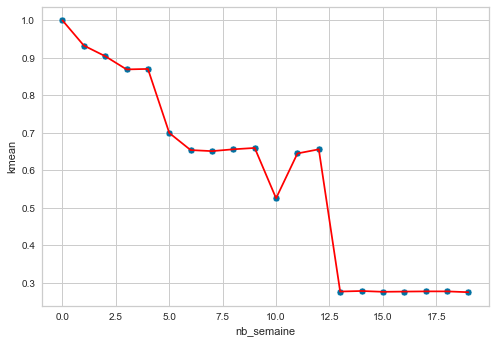

In [20]:
sns.scatterplot(data=ari_result, x='nb_semaine', y='kmean')
sns.lineplot(data=ari_result, x='nb_semaine', y='kmean', color='red')

<AxesSubplot:xlabel='nb_semaine', ylabel='dbscan'>

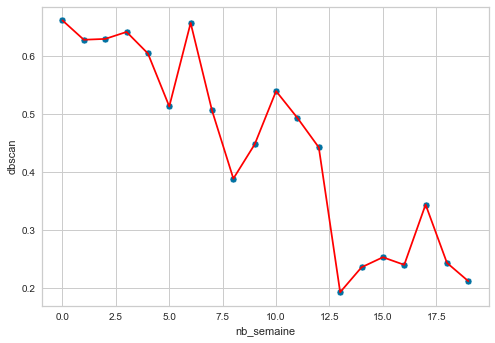

In [21]:
sns.scatterplot(data=ari_result, x='nb_semaine', y='dbscan')
sns.lineplot(data=ari_result, x='nb_semaine', y='dbscan', color='red')

Le modèle dbscan n'a même pas 70 de score ARI pour des données identiques, le modèle n'est pas stable 

En revanche le modèle de kmean a un score ARI supérieur à 85% durant les 5 premières semaines, on choisira donc du préférence ce modèle avec un réentrainement du modèle tous les mois 